# Imports

In [1]:
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
#from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np
import pandas as pd
print('Done')

Done


# Data importing

In [2]:
train = pd.read_csv('dataset.csv')

# Data exploration

In [3]:
train.head(15)

,selected_text,sentiment
0,have responded if were going,0
1,sooo sad,1
2,bullying me,1
3,leave me alone,1
4,sons of,1
5,some shameless plugging for the best rangers f...,0
6,fun,2
7,soooo high,0
8,both of you,0
9,wow just became cooler,2


In [4]:
#Let's get the dataset lenght
len(train)

27481

In [5]:
#Is there any other different value than neutral, negative and positive?
train['sentiment'].unique()

array([0, 1, 2], dtype=int64)

In [6]:
#How's distributed the dataset? Is it biased?
train.groupby('sentiment').nunique()

,selected_text
sentiment,
0,11015
1,4998
2,4498


# Data cleaning

In [7]:
#Let's keep only the columns that we're going to use
train = train[['selected_text','sentiment']]
train.head()

,selected_text,sentiment
0,have responded if were going,0
1,sooo sad,1
2,bullying me,1
3,leave me alone,1
4,sons of,1


In [8]:
#Is there any null value?
train["selected_text"].isnull().sum()

134

In [9]:
#Let's fill the only null value.
train["selected_text"].fillna("No content", inplace = True)

### The next steps about data cleaning will be:

* Remove URLs from the tweets
* Tokenize text
* Remove emails
* Remove new lines characters
* Remove distracting single quotes
* Remove all punctuation signs
* Lowercase all text
* Detokenize text
* Convert list of texts to Numpy array

In [10]:
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

In [11]:
temp = []
#Splitting pd.Series to list
data_to_list = train['selected_text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

['have responded if were going',
 'sooo sad',
 'bullying me',
 'leave me alone',
 'sons of']

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

print(data_words[:10])

[['have', 'responded', 'if', 'were', 'going'], ['sooo', 'sad'], ['bullying', 'me'], ['leave', 'me', 'alone'], ['sons', 'of'], ['some', 'shameless', 'plugging', 'for', 'the', 'best', 'rangers', 'forum', 'on', 'earth'], ['fun'], ['soooo', 'high'], ['both', 'of', 'you'], ['wow', 'just', 'became', 'cooler']]


In [13]:
len(data_words)

27481

In [14]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [15]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['have responded if were going', 'sooo sad', 'bullying me', 'leave me alone', 'sons of']


In [16]:
data = np.array(data)

# Label encoding

As the dataset is categorical, we need to convert the sentiment labels from Neutral, Negative and Positive to a float type that our model can understand. To achieve this task, we'll implement the to_categorical method from Keras.

In [17]:
from tensorflow.keras.utils import to_categorical
labels = np.array(train['sentiment'])
labels = to_categorical(labels, 3, dtype="float32")
labels

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [18]:
len(labels)

27481

# Data sequencing and splitting

We'll implement the Keras tokenizer as well as its pad_sequences method to transform our text data into 3D float data, otherwise our neural networks won't be able to be trained on it.

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...   68  146   41]
 [   0    0    0 ...    0  398   65]
 [   0    0    0 ...    0    0   11]
 ...
 [   0    0    0 ...  373   10    3]
 [   0    0    0 ...   25  543    4]
 [   0    0    0 ... 2424  200  658]]


In [20]:
print(labels)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [21]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

20610 6871 20610 6871


# Model building

Alright, in the next cells I'll guide you through the process of building 3 Recurrent Neural Networks. I'll implement sequential models from the Keras API to achieve this task. Essentially, I'll start with a single layer **LSTM** network which is known by achieving good results in NLP tasks when the dataset is relatively small (I could have started with a SimpleRNN which is even simpler, but to be honest it's actually not deployed in production environments because it is too simple - however I'll leave it commented in case you want to know it's built). The next one will be a Bidirectional LSTM model, a more complex one and this particular one is known to achieve great metrics when talking about text classification. To go beyond the classic NLP approach, finally we'll implement a very unusual model: a Convolutional 1D network, known as well by delivering good metrics when talking about NLP. If everything goes ok, we should get the best results with the BidRNN, let's see what happens.

Let's get hands on:

## SimpleRNN model (Bonus)

In [22]:
#model0 = Sequential()
#model0.add(layers.Embedding(max_words, 15))
#model0.add(layers.SimpleRNN(15))
#model0.add(layers.Dense(3,activation='softmax'))


#model0.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
#checkpoint0 = ModelCheckpoint("best_model0.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
#history = model0.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test),callbacks=[checkpoint0])

## Single LSTM layer model

In [23]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))


model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/70
645/645 [==============================] - 19s 19ms/step - loss: 0.8037 - accuracy: 0.6472 - val_loss: 0.6575 - val_accuracy: 0.7411

Epoch 00001: val_accuracy improved from -inf to 0.74109, saving model to best_model1.hdf5
Epoch 2/70
645/645 [==============================] - 12s 18ms/step - loss: 0.5954 - accuracy: 0.7604 - val_loss: 0.5450 - val_accuracy: 0.7907

Epoch 00002: val_accuracy improved from 0.74109 to 0.79071, saving model to best_model1.hdf5
Epoch 3/70
645/645 [==============================] - 12s 18ms/step - loss: 0.5192 - accuracy: 0.7959 - val_loss: 0.4991 - val_accuracy: 0.8069

Epoch 00003: val_accuracy improved from 0.79071 to 0.80687, saving model to best_model1.hdf5
Epoch 4/70
645/645 [==============================] - 12s 18ms/step - loss: 0.4859 - accuracy: 0.8120 - val_loss: 0.4820 - val_accuracy: 0.8121

Epoch 00004: val_accuracy improved from 0.80687 to 0.81211, saving model to best_model1.hdf5
Epoch 5/70
645/645 [==============================]

645/645 [==============================] - 12s 18ms/step - loss: 0.3274 - accuracy: 0.8782 - val_loss: 0.4273 - val_accuracy: 0.8396

Epoch 00038: val_accuracy did not improve from 0.84107
Epoch 39/70
645/645 [==============================] - 12s 18ms/step - loss: 0.3305 - accuracy: 0.8763 - val_loss: 0.4269 - val_accuracy: 0.8398

Epoch 00039: val_accuracy did not improve from 0.84107
Epoch 40/70
645/645 [==============================] - 12s 18ms/step - loss: 0.3281 - accuracy: 0.8785 - val_loss: 0.4285 - val_accuracy: 0.8403

Epoch 00040: val_accuracy did not improve from 0.84107
Epoch 41/70
645/645 [==============================] - 12s 18ms/step - loss: 0.3288 - accuracy: 0.8785 - val_loss: 0.4271 - val_accuracy: 0.8387

Epoch 00041: val_accuracy did not improve from 0.84107
Epoch 42/70
645/645 [==============================] - 12s 18ms/step - loss: 0.3265 - accuracy: 0.8799 - val_loss: 0.4232 - val_accuracy: 0.8417

Epoch 00042: val_accuracy improved from 0.84107 to 0.84165, sa

## Bidirectional LTSM model

In [24]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint2])

Epoch 1/70
645/645 [==============================] - 52s 73ms/step - loss: 0.7779 - accuracy: 0.6670 - val_loss: 0.6221 - val_accuracy: 0.7366

Epoch 00001: val_accuracy improved from -inf to 0.73657, saving model to best_model2.hdf5
Epoch 2/70
645/645 [==============================] - 23s 35ms/step - loss: 0.5564 - accuracy: 0.7791 - val_loss: 0.5128 - val_accuracy: 0.8029

Epoch 00002: val_accuracy improved from 0.73657 to 0.80294, saving model to best_model2.hdf5
Epoch 3/70
645/645 [==============================] - 20s 31ms/step - loss: 0.4973 - accuracy: 0.8082 - val_loss: 0.5177 - val_accuracy: 0.7932

Epoch 00003: val_accuracy did not improve from 0.80294
Epoch 4/70
645/645 [==============================] - 20s 30ms/step - loss: 0.4655 - accuracy: 0.8205 - val_loss: 0.4702 - val_accuracy: 0.8157

Epoch 00004: val_accuracy improved from 0.80294 to 0.81575, saving model to best_model2.hdf5
Epoch 5/70
645/645 [==============================] - 19s 29ms/step - loss: 0.4493 - accu

645/645 [==============================] - 19s 30ms/step - loss: 0.3227 - accuracy: 0.8818 - val_loss: 0.4314 - val_accuracy: 0.8393

Epoch 00039: val_accuracy did not improve from 0.84107
Epoch 40/70
645/645 [==============================] - 19s 30ms/step - loss: 0.3156 - accuracy: 0.8841 - val_loss: 0.4291 - val_accuracy: 0.8398

Epoch 00040: val_accuracy did not improve from 0.84107
Epoch 41/70
645/645 [==============================] - 19s 29ms/step - loss: 0.3180 - accuracy: 0.8835 - val_loss: 0.4303 - val_accuracy: 0.8402

Epoch 00041: val_accuracy did not improve from 0.84107
Epoch 42/70
645/645 [==============================] - 19s 30ms/step - loss: 0.3165 - accuracy: 0.8846 - val_loss: 0.4277 - val_accuracy: 0.8415

Epoch 00042: val_accuracy improved from 0.84107 to 0.84151, saving model to best_model2.hdf5
Epoch 43/70
645/645 [==============================] - 20s 30ms/step - loss: 0.3150 - accuracy: 0.8827 - val_loss: 0.4342 - val_accuracy: 0.8390

Epoch 00043: val_accurac

## 1D Convolutional model

Before diving into this model, I know by prior experience that it tends to overfit extremely fast on small datasets. In this sense, just will implement it to show you how to do it in case it's of your interest.

In [25]:
from keras import regularizers
model3 = Sequential()
model3.add(layers.Embedding(max_words, 40, input_length=max_len))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(3,activation='softmax'))
model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model3.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint3])

ModuleNotFoundError: No module named 'keras'

If you check the val_accuracy metric in the training logs you won't find better score than the one achieved by the BidRNN. Again, the previous model is not the best for this task becaue is majorly used for short translation tasks, but the good thing to notice is its speed to train.

Let's move on.

# Best model validation
(Before final commit, the best model obtained was the BidRNN)

In [26]:
from tensorflow.keras import models 
#Let's load the best model obtained during training
best_model = models.load_model("best_model2.hdf5")

In [27]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

215/215 - 4s - loss: 0.4364 - accuracy: 0.8418
Model accuracy:  0.8417988419532776


In [28]:
predictions = best_model.predict(X_test)

## Confusion matrix

Alright, we all know the accuracy is not a good metric to measure how well a model is. That's the reason why I like to always see its confusion matrix, that way I have a better understanding of its classification and generalization ability. Let's plot it.

In [29]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

<AxesSubplot:>

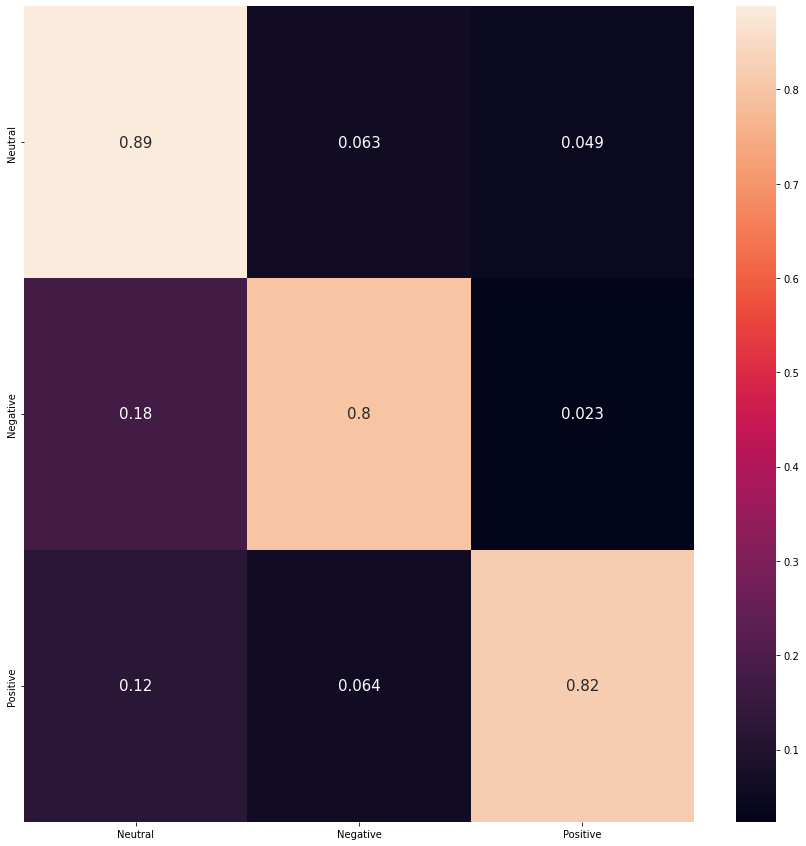

In [30]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

Again, the model's score is very poor, but keep in mind it hasn't gone through hyperparameter tuning. Let's see how it performs on some test text.

In [31]:
sentiment = ['Neutral','Negative','Positive']

In [32]:
sequence = tokenizer.texts_to_sequences(['this experience has been the worst , want my money back'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

In [33]:
sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Positive'

In [34]:
sequence = tokenizer.texts_to_sequences(['i hate youtube ads, they are annoying'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

In [35]:
sequence = tokenizer.texts_to_sequences(['i really loved how the technician helped me with the issue that i had'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Positive'

# Saving model 

In [36]:
#Saving weights and tokenizer so we can reduce training time on SageMaker

# serialize model to JSON
model_json = best_model.to_json()
with open("sentiment_model.json", "w") as json_file:
    json_file.write(model_json)
    
# saving model
best_model.save("sentiment_model.h5")
print("Model saved")

# saving tokenizer
with open('sentiment_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('Tokenizer saved')

Model saved
Tokenizer saved
